# Capstone

### Stock Data Source

*Plan to replace this in the future with a self updating pull using pandas_datareader.data<br>*

- Dow Jones Data Source
https://fred.stlouisfed.org/series/DJIA/downloaddata

- SP500 Data Source
https://fred.stlouisfed.org/series/SP500/downloaddata

## Imports

In [1]:
import pandas as pd
from pandas.tseries.offsets import BDay
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import zipfile
import glob
import urllib
import logging
import pickle
import time as today_time
from random import randint
from scipy.stats import ttest_ind
from xgboost import XGBClassifier

from sklearn import datasets, linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, confusion_matrix, mean_squared_error, precision_score
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score

# Deprecated yet if I use the new version it breaks my code so this stays in until I fix it.
from sklearn.cross_validation import StratifiedKFold


from pydub import AudioSegment
from pydub.playback import play
from datetime import datetime, date, time, timedelta
import pandas_datareader.data as web


seinfeld = AudioSegment.from_mp3("theme.mp3")[:11500]
plt.style.use('fivethirtyeight')
%matplotlib inline

/Users/Jesse/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/Jesse/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Logging

In [2]:
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

# create a file handler
handler = logging.FileHandler('logfile.log')
handler.setLevel(logging.DEBUG)

# create a logging format
formatter = logging.Formatter('%(asctime)s - %(message)s')
handler.setFormatter(formatter)

# add the handlers to the logger
logger.addHandler(handler)

## SP500 Download

In [3]:
df = pd.read_csv('/Users/Jesse/Downloads/SP500.csv')
df['VALUE'] = df['VALUE'].replace('.', np.nan)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df['Date'] = pd.to_datetime(df['DATE'])

df['DATE'] = [''.join(re.findall('(\d*)', df['DATE'][x])[::2]) for x in range(len(df))]

df['Date'] = df['Date'] - timedelta(days=1)
df['Date'] = [str(df['Date'][x].year) + '{:02d}'.format(df['Date'][x].month) + '{:02d}'.format(df['Date'][x].day) for x in range(len(df))]



# This whole section is a temporary bandaide.
# Better implementation to replace the above section on TO-DO list.
start = datetime(2015, 2, 20)
end = datetime(2016, 11, 23)
moob = web.DataReader('SPY', 'google', start, end)
moob.reset_index(inplace=True)
ddf = pd.read_csv('/Users/Jesse/Downloads/SP500.csv')
ddf['VALUE'] = ddf['VALUE'].replace('.', np.nan)
ddf.dropna(inplace=True)
ddf.reset_index(drop=True, inplace=True)
ddf['DATE'] = pd.to_datetime(ddf['DATE'])
moob.set_index(moob['Date'], inplace=True)
ddf.set_index(ddf['DATE'], inplace=True)
ddf['Open'] = moob['Open']
ddf['Close'] = moob['Close']
ddf['day_diff'] = ddf['Close'] - ddf['Open']
ddf.reset_index(drop=True, inplace=True)

# Functions

## Data Download

In [4]:
# Needs more work but pulls data from gdelt and saves it system.
def download_data(day_of, day_before):
    day_before_begin = 144500    # 9:45 am (EST) :  2:45 pm (GMT)
    day_before_end   = 234500    # 6:45 pm (EST) : 11:45 pm (GMT)
    day_of_begin     = 0         # 7:00 pm (EST) : 12:00 am (GMT)
    day_of_end       = 143000    # 9:30 am (EST) :  2:30 pm (GMT)
    while (day_before_begin <= day_before_end):
        x1 = day_before + str(day_before_begin) + '.gkg.csv.zip'
        x2 = 'http://data.gdeltproject.org/gdeltv2/' + x1
        day_before_begin+=1500
        if str(60) in str(day_before_begin):
            day_before_begin+=4000
        x3 = 'capzips/' + x1
        urllib.urlretrieve(x2, x3)
        
    while (day_of_begin <= day_of_end):
        x1 = day_of + '{:06d}'.format(day_of_begin) + '.gkg.csv.zip'
        x2 = 'http://data.gdeltproject.org/gdeltv2/' + x1
        day_of_begin+=1500
        if str(60) in str(day_of_begin):
            day_of_begin+=4000
        x3 = 'capzips/' + x1
        urllib.urlretrieve(x2, x3)
    extract_zip()

# Reads every zip file in the folder and extracts them then deletes the zip.
def extract_zip():
    for name in glob.glob('capzips/*.zip'):
        try:
            with zipfile.ZipFile(name, 'r') as myzip:
                myzip.extractall('capzips/')
                os.remove(name)
        except:
            os.remove(name)

## CSV to DataFrame

In [5]:
# Opens every csv and puts the data into a dataframe
def csv_to_df():
    csv_df = pd.DataFrame()
    #count=0
    for name in glob.glob('capzips/*.csv'):
        try:
            logger.debug('File name: %s', name)
            temp_df = pd.read_csv(name, header=None, sep="\t", usecols=[1,15])
            temp_df['Date'], temp_df['TONE'] = temp_df[1], temp_df[15]
            temp_df = temp_df[['Date', 'TONE']]
            
            # This section is necessary do not remove.
            if temp_df['Date'].dtypes != 'int64':
                temp_df.dropna(inplace=True)
                temp_df['Date'] = temp_df['Date'].astype(int)
        
            csv_df = pd.concat((csv_df,temp_df), ignore_index=True)
        except:
            logger.debug('File is empty: %s', name)
        #count+=1
    return csv_df


# Deletes the CSVs
def delete_csv():
    for name in glob.glob('capzips/*.csv'):
        os.remove(name)

## Random Functions

In [6]:
# Used to run data collection in specified time increments.
# Current implementation takes 5 minutes to run.
def run_time(t, x):
    if x == 'm':
        return t/5
    else:
        return (t*60)/5


def tone_parse(cvs):
    cvs['tone'] = [float(x.split(',')[0]) for x in cvs['TONE']]
    cvs['positive_score'] = [float(x.split(',')[1]) for x in cvs['TONE']]
    cvs['negative_score'] = [float(x.split(',')[2]) for x in cvs['TONE']]
    cvs['polarity'] = [float(x.split(',')[3]) for x in cvs['TONE']]
    cvs['activity'] = [float(x.split(',')[4]) for x in cvs['TONE']]
    cvs['word_count'] = [int(x.split(',')[6]) for x in cvs['TONE']]
    cvs.pop('TONE')
    return cvs

def putfirst(n,df):
    if not isinstance(n, int):
        print 'error: 1st arg must be an int'
        return
    if n < 1:
        print 'error: 1st arg must be an int > 0'
        return
    if n == 1:
       print 'nothing to do when first arg == 1'
       return
    if n > len(df):
       print 'error: n exceeds the number of rows in the DataFrame'
       return
    df.index = range(1,n) + [0] + range(n,df.index[-1]+1)
    df.sort(inplace=True)

## Daily Updates

In [7]:
def today_data():
    test_variable = today_time.strftime("%Y%m%d")
    date_variable = pd.to_datetime(test_variable) - timedelta(days=1)
    date_variable = str(date_variable.year) + '{:02d}'.format(date_variable.month) + '{:02d}'.format(date_variable.day)

    download_data(test_variable, date_variable)
    csv_df = tone_parse(csv_to_df())
    csv_df['Date'] = [pd.to_datetime(datetime.strptime(str(x), '%Y%m%d%H%M%S')) for x in csv_df['Date']]
    csv_df = csv_df.set_index('Date')
    csv_df = csv_df.resample('h').mean()
    csv_df.dropna(inplace=True)
    csv_df.reset_index(inplace=True)
    temp = csv_df.columns[1:]
    test = pd.DataFrame([np.polyfit(csv_df.index, csv_df[x],1)[0] for x in csv_df.columns[1:].tolist()]).T
    test.columns = temp.tolist()
    test['Date'] = test_variable
    delete_csv()
    update_df = pd.read_pickle('update_df.pkl')
    update_df = pd.concat((update_df, test), ignore_index=True)
    pd.to_pickle(update_df, 'update_df.pkl')


def update():
    update_df = pd.read_pickle('update_df.pkl')
    
    # Might be able to remove this in the future if I get a better original data collection system.
    start = datetime(2017, 1, 1)
    end = datetime(2017, 12, 31)
    bt = web.DataReader('SPY', 'google', start, end)
    bt = bt.tail(1)
    bt.reset_index(inplace=True)
    bt['day_diff'] = bt['Close'] - bt['Open']
    bt['high_diff'] = bt['High'] - bt['Open']
    
    
    update_df['value'][len(update_df)-1] = bt['day_diff']
    
    if update_df['value'][len(update_df)-1] > 0:
        update_df['value_binary'][len(update_df)-1] = 1
    else:
        update_df['value_binary'][len(update_df)-1] = 0
    
    pd.to_pickle(update_df, 'update_df.pkl')

# Model Functions

## XG Boost Predict

In [8]:
def xgboost_prediction():
    lr = XGBClassifier()
    lr.fit(X_train, Y_train)
    y_pred = lr.predict(X_test)
    y_score = lr.predict_proba(X_test)
    if y_pred[0]==0:
        return 0
    else:
        return 1

## Logistic Regression Predict

In [9]:
def logistic_regression_prediction():
    lr = LogisticRegressionCV(Cs=35, cv=10, solver='liblinear')
    lr.fit(X_train, Y_train)
    y_pred = lr.predict(X_test)
    y_score = lr.predict_proba(X_test)
    if y_pred[0]==0:
        return 0
    else:
        return 1

## Decision Tree Predict

In [10]:
# This runs Decision Tree 10 times and takes the highest performing result as the answer.
def decision_tree_prediction():
    max_down = 0
    max_up = 0
    
    param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
                  "base_estimator__splitter" :   ["best", "random"],
                  "n_estimators": [1, 2]}

    for count in range(10):
        dtc = DecisionTreeClassifier(min_samples_leaf=10, presort=True)
        ABC = AdaBoostClassifier(base_estimator = dtc)
        gs = GridSearchCV(ABC, param_grid=param_grid, n_jobs=-1)
        gs.fit(X_train,Y_train)
        y_pred = gs.predict_proba(X_test)


        if y_pred[0][0] > max_down:
            max_down = y_pred[0][0]
        if y_pred[0][1] > max_up:
            max_up = y_pred[0][1]
            
    
    if max_down > max_up:
        return 0
    else:
        return 1

## KNeighbors Predict

In [11]:
# This runs Decision Tree 10 times and takes the highest performing result as the answer.
def kneighbors_prediction():
    kc = KNeighborsClassifier()
    gs = GridSearchCV(kc, {}, cv=2)

    gs.fit(X_train,Y_train)
    y_pred = gs.predict(X_test)
    y_score = gs.predict_proba(X_test)
    if y_pred[0]==0:
        return 0
    else:
        return 1

## Extra Trees Predict

In [12]:
def extra_trees_prediction():
    classif = ExtraTreesClassifier(min_samples_leaf=10)
    gs = GridSearchCV(classif, {'n_estimators': np.arange(90,101,10),'max_features': np.arange(1,7,1)}, cv=2)

    gs.fit(X_train,Y_train)
    y_pred = gs.predict(X_test)
    y_score = gs.predict_proba(X_test)
    if y_pred[0]==0:
        return 0
    else:
        return 1

## Random Forest Predict


In [13]:
def random_forest_prediction():
    classif = RandomForestClassifier(min_samples_leaf=10)
    gs = GridSearchCV(classif, {'n_estimators': np.arange(90,101,10),'max_features': np.arange(1,7,1)}, cv=2)

    gs.fit(X_train,Y_train)
    y_pred = gs.predict(X_test)
    y_score = gs.predict_proba(X_test)
    if y_pred[0]==0:
        return 0
    else:
        return 1

## Ensemble Predict

In [14]:
def ensemble_predict():
    if (xgboost_prediction() + logistic_regression_prediction() + decision_tree_prediction() + kneighbors_prediction() + extra_trees_prediction() + random_forest_prediction()) >=4:
        return 1
    else:
        return 0

# Backtest Main

In [15]:
def main_func(time_run):
    if time_run == 0:
        return "Not enough time to finish one loop."
    
    # We good fam.
    try:
        final_df = pd.read_pickle('last_df.pkl')
    except IOError:
        final_df = pd.DataFrame()
    
    
    # Prevents my program from running over and breaking.
    if len(final_df)+time_run >= len(df):
        upper_bound = len(df)-1
    else:
        upper_bound = len(final_df)+time_run
    
    # Main for loop that downloads, cleans, and stores relevant data.
    for p in range(len(final_df), upper_bound):
        # Downloads the data from the internet for the specified date.
        download_data(df['DATE'][p], df['Date'][p])
        
        
        # --------- TONE Section -------- #
        csv_df = tone_parse(csv_to_df())
        csv_df['Date'] = [pd.to_datetime(datetime.strptime(str(x), '%Y%m%d%H%M%S')) for x in csv_df['Date']]
        csv_df = csv_df.set_index('Date')
        csv_df = csv_df.resample('h').mean()
        csv_df.dropna(inplace=True)
        csv_df.reset_index(inplace=True)
        temp = csv_df.columns[1:]
        test = pd.DataFrame([np.polyfit(csv_df.index, csv_df[x],1)[0] for x in csv_df.columns[1:].tolist()]).T
        test.columns = temp.tolist()
        # --------- TONE Section -------- #

        
        final_df = pd.concat([final_df, test], ignore_index=True)
        delete_csv()
        final_df['Date'] = df['DATE']
        pd.to_pickle(final_df, 'last_df.pkl')
        final_df = pd.read_pickle('last_df.pkl')
    play(seinfeld)

In [16]:
# Runs main function
# main_func(run_time(20, 'm')) # m = minutes, h = hours      1 loop = ~5 minutes

In [79]:
# Test Model Performance by finding mean scores of 100 runs.
# Problem is this finds the mean of different Y's which have different values every time.
# This is bad.

final_results = []
default_results = []
test_results = []
base_accuracy = []
random_accuracy = []
better_count = 0

for count in range(1000):
    X = update_df[['activity', 'negative_score', 'polarity',\
                   'positive_score', 'tone', 'word_count',\
                   'word_count_mean', 'positive_mean']]
    y = update_df['value_binary']

    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, stratify=y)
    
    
    
#     X_train = testDF[[1,2,3,4,5,6,8,9]][:-10]
#     Y_train = testDF['value_binary'][:-10]

#     X_test = testDF[[1,2,3,4,5,6,8,9]][-10:]
#     Y_test = testDF['value_binary'][-10:]

    
    
    #lr = XGBClassifier()
    lr = LogisticRegressionCV(Cs=35, cv=10)
    lr.fit(X_train,Y_train)

    y_pred = lr.predict(X_test)
    
    randomguess = []
    for numder in range(len(X_test)):
        randomguess.append(randint(0,1))

    #--------This section needs to be re-evaluated and editted--------#  Done?
    Y_test_index = pd.DataFrame(Y_test).reset_index()
    Y_test_and_predict = pd.concat((Y_test_index, pd.DataFrame(y_pred)),axis=1)

    Y_test_and_predict = Y_test_and_predict.set_index('index')
    Y_test_and_predict['guess'] = Y_test_and_predict[0]
    Y_test_and_predict.pop(0)
    fest = pd.concat((Y_test_and_predict, update_df['value']), axis=1).dropna()
    fest.reset_index(drop=True, inplace=True)

    results = 0
    for x in range(len(fest)):
        if fest['guess'][x] == 1:
            if fest['value_binary'][x] == fest['guess'][x]:
                results += abs(fest['value'][x])
            else:
                results -= abs(fest['value'][x])
    
    random_results = 0
    for x in range(len(fest)):
        if randomguess[x] == 1:
            if fest['value_binary'][x] == randomguess[x]:
                random_results += abs(fest['value'][x])
            else:
                random_results -= abs(fest['value'][x])
    #---------------------------------------------------------------#
    
    final_results.append(results)
    random_accuracy.append(random_results)
    
    conmat = confusion_matrix(Y_test, y_pred, labels=[1,0])
    test_results.append((conmat[0][0]+conmat[1][1])/float(len(Y_test)))
    
    #if conmat[0][0] + conmat[0][1] > conmat[1][0] + conmat[1][1]:
    base_accuracy.append((conmat[0][0]+conmat[0][1])/float(len(Y_test)))
    #else:
    #    base_accuracy.append((conmat[1][0]+conmat[1][1])/float(len(Y_test)))
    
    right_pos = [x for x in fest['value'] if x > 0]
    right_neg = [x for x in fest['value'] if x < 0]
    dresults = np.sum(right_pos) - abs(np.sum(right_neg))
    default_results.append(dresults)
    
    if results >= dresults:
        better_count+=1
print "Mean S&P500 Model Performance:", np.mean(final_results), "Ignore."
print "Mean S&P500  Base Performance:", np.mean(default_results), "Ignore."
print 'Mean of Model Accuracy:', np.mean(test_results)
print 'Mean of  Base Accuracy:', np.mean(base_accuracy)
print 'Model Standard Deviation:', np.std(test_results).round(3)
print 'Number of times model is better than random chance. Out of 1000:', better_count

Mean S&P500 Model Performance: 9.6056 Ignore.
Mean S&P500  Base Performance: 6.65538 Ignore.
Mean of Model Accuracy: 0.524834586466
Mean of  Base Accuracy: 0.518796992481
Model Standard Deviation: 0.034
Number of times model is better than random chance. Out of 1000: 670


In [214]:
for x in range(len(test_results)):
    t_score = test_results[x] - base_accuracy[x]
np.sum(t_score)

0.045454545454545414

In [485]:
for x in range(len(final_results)):
    t_score = final_results[x] - default_results[x]
np.sum(t_score)

2.0899999999999181

In [484]:
ttest_ind(final_results, random_accuracy)

Ttest_indResult(statistic=19.90214950132987, pvalue=1.4918316571797486e-80)

In [486]:
np.mean(random_accuracy)

3.4935299999999923

In [487]:
conmat = np.array(confusion_matrix(Y_test, y_pred, labels=[1,0]))
confusion = pd.DataFrame(conmat, index=['over', 'under'],
                            columns=['predicted_over','predicted_under'])

print(confusion)
print classification_report(Y_test,y_pred)

       predicted_over  predicted_under
over               41               29
under              37               28
             precision    recall  f1-score   support

          0       0.49      0.43      0.46        65
          1       0.53      0.59      0.55        70

avg / total       0.51      0.51      0.51       135



# Decision Tree

In [100]:
# Test Model Performance by finding mean scores of 100 runs.
# Problem is this finds the mean of different Y's which have different values every time.
# This is bad.

update_df = pd.read_pickle('update_df.pkl')
update_df['word_count_mean'] = update_df['word_count'].rolling(window=7, center=False).mean()
update_df['positive_mean'] = update_df['positive_score'].rolling(window=7, center=False).mean()
update_df = update_df.ix[:][6:]
update_df.reset_index(drop=True, inplace=True)

max_down = 0
max_up = 0
Y_pred = []
a=-1
b=0

param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "n_estimators": [1, 2]}

for dcount in range(1):
    for count in range(10):
        if dcount == 0:
            X_train = update_df[['activity', 'negative_score', 'polarity',\
                                 'positive_score', 'tone', 'word_count',\
                                 'word_count_mean', 'positive_mean']][:-1]
            Y_train = update_df['value_binary'][:-1]

            X_test = update_df[['activity', 'negative_score', 'polarity',\
                                'positive_score', 'tone', 'word_count',\
                                'word_count_mean', 'positive_mean']][-1:]
            Y_test = update_df['value_binary'][-1:]

        else:
            X_train = update_df[['activity', 'negative_score',\
                                 'polarity', 'positive_score',\
                                 'tone', 'word_count']][:a]
            Y_train = update_df['value_binary'][:a]

            X_test = update_df[['activity', 'negative_score',\
                                 'polarity', 'positive_score',\
                                 'tone', 'word_count']][a:b]
            Y_test = update_df['value_binary'][a:b]

        
        dtc = DecisionTreeClassifier(min_samples_leaf=10, presort=True)
        ABC = AdaBoostClassifier(base_estimator = dtc)
        gs = GridSearchCV(ABC, param_grid=param_grid, n_jobs=-1)
        gs.fit(X_train,Y_train)
        y_pred = gs.predict_proba(X_test)
        
        
#         lr = LogisticRegressionCV(Cs=20, cv=2)
#         lr.fit(X_train, Y_train)
#         y_pred = lr.predict(X_test)
#         y_score = lr.decision_function(X_test)


        if y_pred[0][0] > max_down:
            max_down = y_pred[0][0]
        if y_pred[0][1] > max_up:
            max_up = y_pred[0][1]
    
    a-=1    
    b-=1
    
    if max_down > max_up:
        Y_pred.append(0)
    else:
        Y_pred.append(1)

a+=1
Y_test = update_df['value_binary'][a:]
Y_pred.reverse()
conmat = np.array(confusion_matrix(Y_test, Y_pred, labels=[1,0]))
confusion = pd.DataFrame(conmat, index=['over', 'under'],
                            columns=['predicted_over','predicted_under'])

print confusion

       predicted_over  predicted_under
over                0                1
under               0                0


# Logistic Regression

In [103]:
#Single Logistic Regression model.
X_train = update_df[['activity', 'negative_score',\
                     'polarity', 'positive_score',\
                     'tone', 'word_count', 'word_count_mean',\
                     'positive_mean']][:-30]
Y_train = update_df['value_binary'][:-30]

X_test = update_df[['activity', 'negative_score',\
                     'polarity', 'positive_score',\
                     'tone', 'word_count', 'word_count_mean',\
                     'positive_mean']][-30:]
Y_test = update_df['value_binary'][-30:]


# lr = XGBClassifier()
lr = LogisticRegressionCV(Cs=35, cv=10, solver='liblinear')
lr.fit(X_train, Y_train)
y_pred = lr.predict(X_test)
y_score = lr.decision_function(X_test)


# dtc = DecisionTreeClassifier(min_samples_leaf=10, presort=True)
# ABC = AdaBoostClassifier(base_estimator = dtc)
# gs = GridSearchCV(ABC, param_grid=param_grid, n_jobs=-1)
# gs.fit(X_train,Y_train)
# y_pred = gs.predict(X_test)




conmat = np.array(confusion_matrix(Y_test, y_pred, labels=[1,0]))
confusion = pd.DataFrame(conmat, index=['over', 'under'],
                            columns=['predicted_over','predicted_under'])

print(confusion)
print classification_report(Y_test,y_pred)

       predicted_over  predicted_under
over               18                2
under               7                3
             precision    recall  f1-score   support

        0.0       0.60      0.30      0.40        10
        1.0       0.72      0.90      0.80        20

avg / total       0.68      0.70      0.67        30



ROC Area Under Curve Score: 0.61


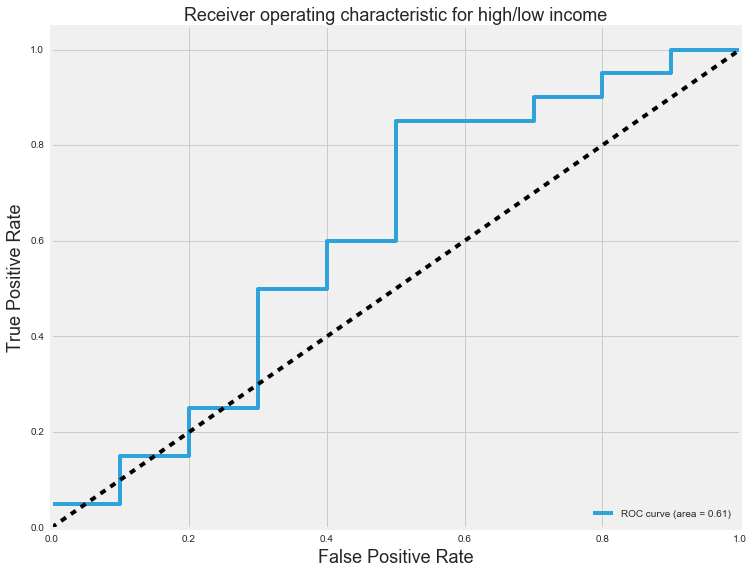

In [104]:
print 'ROC Area Under Curve Score:', roc_auc_score(Y_test, y_score)
""" Plot AUC"""

FPR = dict()
TPR = dict()
ROC_AUC = dict()

# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(Y_test, y_score)
ROC_AUC[1] = auc(FPR[1], TPR[1])

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for high/low income', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [105]:
coef = pd.DataFrame([X.columns.values.tolist(), lr.coef_[0].tolist()], index=['features', 'coef']).T
coef.sort_values(by='coef', ascending=False)

,features,coef
5,word_count,0.047174
6,word_count_mean,0.0385347
2,polarity,0.000689431
3,positive_score,0.000584617
4,tone,0.000479803
1,negative_score,0.000104814
7,positive_mean,-6.37815e-05
0,activity,-0.000807619


In [107]:
# This method of optimization decreases precision and increases False Negatives and decreases True Positives

logreg = LogisticRegression(solver='liblinear')
C_vals = [0.0001, 0.001, 0.01, 0.1, .15, .25, .275, .33, 0.5, .66, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]
penalties = ['l1','l2']

gs = GridSearchCV(logreg, {'penalty': penalties, 'C': C_vals}, verbose=False, cv=35)
gs.fit(X_train, Y_train)

logreg = LogisticRegression(C=gs.best_params_['C'],penalty=gs.best_params_['penalty'])
cv_model = logreg.fit(X_train, Y_train)
cv_pred = cv_model.predict(X_test)

conmat = np.array(confusion_matrix(Y_test, cv_pred, labels=[1,0]))
confusion = pd.DataFrame(conmat, index=['over', 'under'],
                            columns=['predicted_over','predicted_under'])
print(confusion)
print classification_report(Y_test, cv_pred)

       predicted_over  predicted_under
over               18                2
under               7                3
             precision    recall  f1-score   support

        0.0       0.60      0.30      0.40        10
        1.0       0.72      0.90      0.80        20

avg / total       0.68      0.70      0.67        30



# Cluster Models.

In [108]:
X = update_df[['activity', 'negative_score',\
                     'polarity', 'positive_score',\
                     'tone', 'word_count', 'word_count_mean',\
                     'positive_mean']][:-1]
y = update_df['value_binary'][:-1]

cv = StratifiedKFold(y, n_folds=100, shuffle=True, random_state=69)

dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
et = ExtraTreesClassifier()
kc = KNeighborsClassifier()

bdt = BaggingClassifier(dt)
brf = BaggingClassifier(rf)
bet = BaggingClassifier(et)
bkc = BaggingClassifier(kc)

cdt = cross_val_score(dt, X, y, cv=cv, n_jobs=-1)
crf = cross_val_score(rf, X, y, cv=cv, n_jobs=-1)
cet = cross_val_score(et, X, y, cv=cv, n_jobs=-1)
ckc = cross_val_score(kc, X, y, cv=cv, n_jobs=-1)

cbdt = cross_val_score(bdt, X, y, cv=cv, n_jobs=-1)
cbrf = cross_val_score(brf, X, y, cv=cv, n_jobs=-1)
cbet = cross_val_score(bet, X, y, cv=cv, n_jobs=-1)
cbkc = cross_val_score(bkc, X, y, cv=cv, n_jobs=-1)


print("{} Score:\t{:0.3} ± {:0.3}".format("Decision Tree", cdt.mean().round(3), cdt.std().round(3)))
print("{} Score:\t{:0.3} ± {:0.3}".format("Random Forest", crf.mean().round(3), crf.std().round(3)))
print("{} Score:\t{:0.3} ± {:0.3}".format("Extra Trees", cet.mean().round(3), cet.std().round(3)))
print("{} Score:\t{:0.3} ± {:0.3}".format("Nearest Neighbor", ckc.mean().round(3), ckc.std().round(3)))
print 
print("{} Score:\t{:0.3} ± {:0.3}".format("Decision Tree Bagging", cbdt.mean().round(3), cbdt.std().round(3)))
print("{} Score:\t{:0.3} ± {:0.3}".format("Random Forest Bagging", cbrf.mean().round(3), cbrf.std().round(3)))
print("{} Score:\t{:0.3} ± {:0.3}".format("Extra Trees Bagging", cbet.mean().round(3), cbet.std().round(3)))
print("{} Score:\t{:0.3} ± {:0.3}".format("Nearest Neighbor Bagging", cbkc.mean().round(3), cbkc.std().round(3)))

Decision Tree Score:	0.532 ± 0.243
Random Forest Score:	0.539 ± 0.231
Extra Trees Score:	0.475 ± 0.256
Nearest Neighbor Score:	0.543 ± 0.219

Decision Tree Bagging Score:	0.557 ± 0.216
Random Forest Bagging Score:	0.553 ± 0.229
Extra Trees Bagging Score:	0.538 ± 0.228
Nearest Neighbor Bagging Score:	0.542 ± 0.22


Decision Tree Score:	0.57 ± 0.229
Random Forest Score:	0.49 ± 0.242
Extra Trees Score:	0.526 ± 0.245
Nearest Neighbor Score:	0.565 ± 0.254

Decision Tree Bagging Score:	0.522 ± 0.245
Random Forest Bagging Score:	0.541 ± 0.248
Extra Trees Bagging Score:	0.506 ± 0.226
Nearest Neighbor Bagging Score:	0.544 ± 0.246

,dt_importance,rf_importance,et_importance
positive_mean,0.199219,0.114836,0.137168
word_count,0.188449,0.101858,0.127099
polarity,0.147181,0.119414,0.125191
tone,0.121672,0.102973,0.117606
word_count_mean,0.116747,0.122269,0.130807
positive_score,0.083995,0.155316,0.116527
negative_score,0.081259,0.125351,0.113964
activity,0.061477,0.157983,0.131638


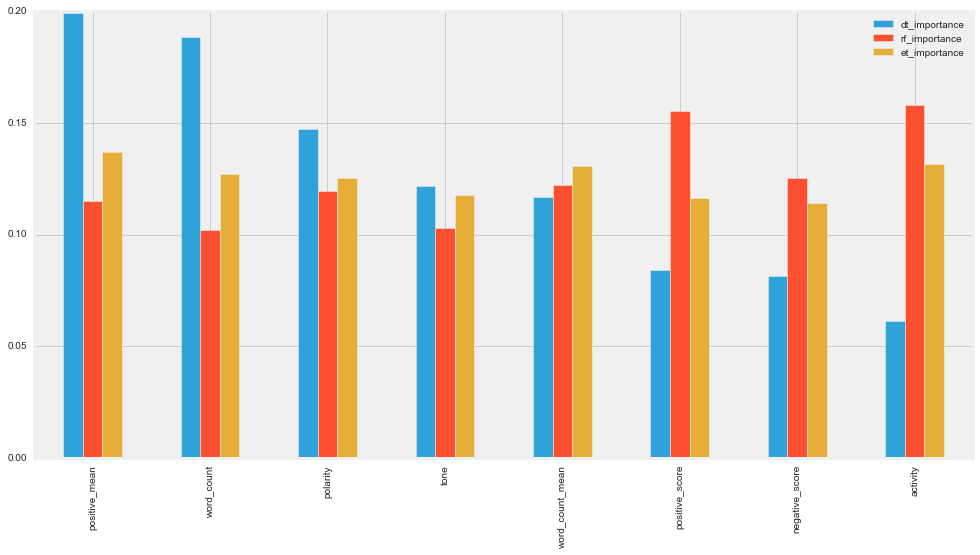

In [123]:
dt.fit(X, y)
rf.fit(X, y)
et.fit(X, y)

importances = pd.DataFrame(zip(dt.feature_importances_,
                               rf.feature_importances_,
                               et.feature_importances_),
                           index=X.columns,
                           columns=['dt_importance',
                                    'rf_importance',
                                    'et_importance']).sort_values('dt_importance',
                                                                   ascending=False)

                           
importances.plot(kind='bar', figsize=(15,8))
importances.head(10)

       predicted_over  predicted_under
over               10                3
under               3                4
             precision    recall  f1-score   support

          0       0.57      0.57      0.57         7
          1       0.77      0.77      0.77        13

avg / total       0.70      0.70      0.70        20

ROC Area Under Curve Score: 0.714285714286


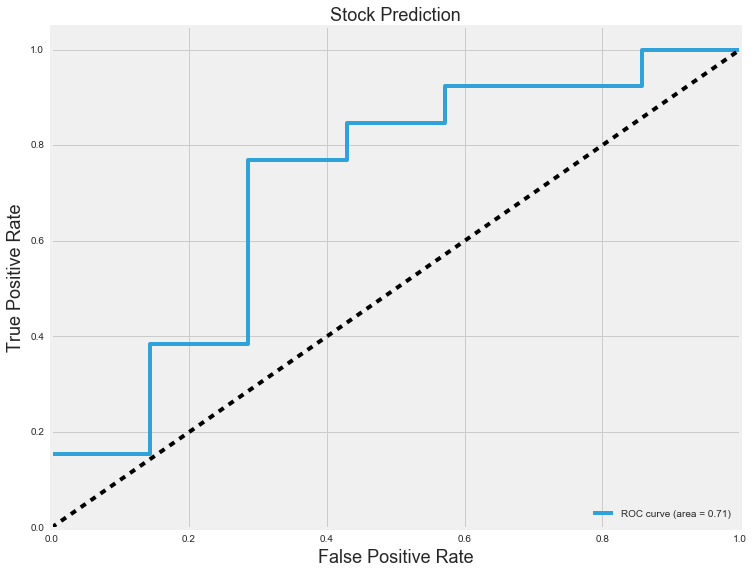

In [734]:
# GridSearch ExtraTrees. Unused.

gs2 = GridSearchCV(ExtraTreesClassifier(min_samples_leaf=10),
                  {'n_estimators': np.arange(90,100,10),
                  'max_features': np.arange(1,5,1)},
                  cv=10)
gs2.fit(X_train,Y_train)
y_pred2 = gs2.predict_proba(X_test)
tempDF = pd.DataFrame(y_pred2)
tempDF['actual'] = np.array(Y_test)
tempDF['threshold'] = tempDF[1].map(lambda x: 0 if x < 0.5 else 1)



conmat = np.array(confusion_matrix(Y_test, tempDF['threshold'], labels=[1,0]))
confusion = pd.DataFrame(conmat, index=['over', 'under'],
                            columns=['predicted_over','predicted_under'])

print(confusion)
print classification_report(Y_test, tempDF['threshold'])

print 'ROC Area Under Curve Score:', roc_auc_score(Y_test, tempDF[1])
""" Plot AUC"""

FPR = dict()
TPR = dict()
ROC_AUC = dict()

# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(Y_test, tempDF[1])
ROC_AUC[1] = auc(FPR[1], TPR[1])

# Plot of a ROC curve for class 1
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Stock Prediction', fontsize=18)
plt.legend(loc="lower right")
plt.show()

# Testing Model Results

In [115]:
# Tests model and compares with value change.
# Rewrite this section to make decisions based on the 5 models
# and then sketch win/loss based off of the ensemble.

final_results = []
default_results = []
model_accuracy = []
base_accuracy = []


number_of_days = -40

for count in range(1):
    
    X_train = update_df[['activity', 'negative_score',\
                     'polarity', 'positive_score',\
                     'tone', 'word_count', 'word_count_mean',\
                     'positive_mean']][:number_of_days]
    Y_train = update_df['value_binary'][:number_of_days]

    X_test = update_df[['activity', 'negative_score',\
                     'polarity', 'positive_score',\
                     'tone', 'word_count', 'word_count_mean',\
                     'positive_mean']][number_of_days:]
    Y_test = update_df['value_binary'][number_of_days:]

    
    
    #lr = XGBClassifier()
    lr = LogisticRegressionCV(Cs=35, cv=10, solver='liblinear')
    lr.fit(X_train,Y_train)
    y_pred = lr.predict(X_test)
    

    
    #--------This section needs to be re-evaluated and editted--------#  Done?
    Y_test_index = pd.DataFrame(Y_test).reset_index()
    Y_test_and_predict = pd.concat((Y_test_index, pd.DataFrame(y_pred)),axis=1)

    Y_test_and_predict = Y_test_and_predict.set_index('index')
    Y_test_and_predict['guess'] = Y_test_and_predict[0]
    Y_test_and_predict.pop(0)
    
    
    fest = pd.concat((Y_test_and_predict, update_df['value'][number_of_days:]), axis=1).dropna()
    #fest = pd.concat((fest, update_df['high_diff'][-20:]), axis=1).dropna()
    fest.reset_index(drop=True, inplace=True)
    
    results = 0
    for x in range(len(fest)):
        if fest['guess'][x] == 1:
            if fest['value_binary'][x] == fest['guess'][x]:
                    results += abs(fest['value'][x]) 
            else:
                    results -= abs(fest['value'][x])
#         else:
#             if fest['high_diff'][x] >= .5:
#                 results+=.5
#             elif abs(fest['value'][x]) >= .5:  # Best case scenario
#                 results-=.5
#             else:
#                 results-=abs(fest['value'][x])
    #---------------------------------------------------------------#
    
    final_results.append(results)
    
    conmat = confusion_matrix(Y_test, y_pred, labels=[1,0])
    
    model_accuracy.append((conmat[0][0]+conmat[1][1])/float(len(Y_test)))
    base_accuracy.append((conmat[0][0]+conmat[0][1])/float(len(Y_test)))
    
    default_results.append(fest['value'].sum())

print "S&P500 Model Performance:", np.mean(final_results)
print "S&P500  Base Performance:", np.mean(default_results)
print '          Model Accuracy:', np.mean(model_accuracy)
print '           Base Accuracy:', np.mean(base_accuracy)

S&P500 Model Performance: 8.69
S&P500  Base Performance: 6.02
          Model Accuracy: 0.625
           Base Accuracy: 0.55


# Predict Main

In [122]:
update_df = pd.read_pickle('update_df.pkl')
update_df['word_count_mean'] = update_df['word_count'].rolling(window=7, center=False).mean()
update_df['positive_mean'] = update_df['positive_score'].rolling(window=7, center=False).mean()
update_df = update_df.ix[:][6:]
update_df.reset_index(drop=True, inplace=True)

X_train = update_df[['activity', 'negative_score', 'polarity',\
                   'positive_score', 'tone', 'word_count',\
                   'word_count_mean', 'positive_mean']][:-1]
Y_train = update_df['value_binary'][:-1]
X_test = update_df[['activity', 'negative_score', 'polarity',\
                   'positive_score', 'tone', 'word_count',\
                   'word_count_mean', 'positive_mean']][-1:]


if ensemble_predict() == 1:
    print "Predicted Up"
else:
    print "Predicted Down"

Predicted Down


In [51]:
update_df = pd.read_pickle('update_df.pkl')
update_df['word_count_mean'] = update_df['word_count'].rolling(window=7, center=False).mean()
update_df['positive_mean'] = update_df['positive_score'].rolling(window=7, center=False).mean()
update_df = update_df.ix[:][6:]
update_df.reset_index(drop=True, inplace=True)


a = -2
b = -1
guesses = []

X_train = update_df[['activity', 'negative_score',\
                         'polarity', 'positive_score',\
                         'tone', 'word_count']][:-1]
Y_train = update_df['value_binary'][:-1]
X_test = update_df[['activity', 'negative_score', 'polarity', 'positive_score', 'tone', 'word_count']][-1:]

#------------------------#
guesses.append(ensemble_predict())
#------------------------#

for count in range(30):
    X_train = update_df[['activity', 'negative_score',\
                         'polarity', 'positive_score',\
                         'tone', 'word_count']][:a]
    Y_train = update_df['value_binary'][:a]
    X_test = update_df[['activity', 'negative_score', 'polarity', 'positive_score', 'tone', 'word_count']][a:b]

    #------------------------#
    guesses.append(ensemble_predict())
    #------------------------#
    
    a-=1
    b-=1

a+=1
Y_test = update_df['value_binary'][a:]
guesses.reverse()
conmat = np.array(confusion_matrix(Y_test, guesses, labels=[1,0]))
confusion = pd.DataFrame(conmat, index=['over', 'under'],
                            columns=['predicted_over','predicted_under'])

print confusion
print classification_report(Y_test,guesses)

       predicted_over  predicted_under
over               11                8
under               5                7
             precision    recall  f1-score   support

        0.0       0.47      0.58      0.52        12
        1.0       0.69      0.58      0.63        19

avg / total       0.60      0.58      0.59        31



In [23]:
# This runs Decision Tree 10 times and takes the highest performing result as the answer.
def decision_tree_prediction_temp():
    max_down = 0
    max_up = 0
    
    param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
                  "base_estimator__splitter" :   ["best", "random"],
                  "n_estimators": [1, 2]}

    for count in range(10):
        dtc = DecisionTreeClassifier(min_samples_leaf=10, presort=True)
        ABC = AdaBoostClassifier(base_estimator = dtc)
        gs = GridSearchCV(ABC, param_grid=param_grid, n_jobs=-1)
        gs.fit(X_train,Y_train)
        y_pred = gs.predict_proba(X_test)


        if y_pred[0][0] > max_down:
            max_down = y_pred[0][0]
        if y_pred[0][1] > max_up:
            max_up = y_pred[0][1]

    if max_up > .8:
        return 1
    else:
        return 0

# Update

In [139]:
update_df = pd.read_pickle('update_df.pkl')

# # Grabs the latest day's info and puts it into the dataset.
# if update_df['Date'][len(update_df)-1] != today_time.strftime("%Y%m%d"):

# # The runs the function that adds 'value' and 'value_binary to the dataset.
# if update_df['value_binary'][len(update_df)-1] != 0 and update_df['value_binary'][len(update_df)-1] != 1:
#     if int(today_time.strftime("%H%M")) > 1730:




today_data()

update_df = pd.read_pickle('update_df.pkl')
update_df['word_count_mean'] = update_df['word_count'].rolling(window=7, center=False).mean()
update_df['positive_mean'] = update_df['positive_score'].rolling(window=7, center=False).mean()
update_df = update_df.ix[:][6:]
update_df.reset_index(drop=True, inplace=True)

X_train = update_df[['activity', 'negative_score', 'polarity',\
                   'positive_score', 'tone', 'word_count',\
                   'word_count_mean', 'positive_mean']][:-1]
Y_train = update_df['value_binary'][:-1]
X_test = update_df[['activity', 'negative_score', 'polarity',\
                   'positive_score', 'tone', 'word_count',\
                   'word_count_mean', 'positive_mean']][-1:]


if ensemble_predict() == 1:
    print "Predicted Up"
else:
    print "Predicted Down"

Predicted Up


In [137]:
update_df = pd.read_pickle('update_df.pkl')
update()

/Users/Jesse/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Jesse/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [138]:
update_df = pd.read_pickle('update_df.pkl')
update_df.tail()

,Date,activity,negative_score,polarity,positive_score,tone,value,value_binary,word_count
462,20170111,-0.011718,-0.002851,-0.005247,-0.002396,0.000454,0.74,1.0,1.366671
463,20170112,-0.009486,-0.005279,-0.004030,0.001249,0.006528,0.03,1.0,0.553377
464,20170113,0.000301,-0.008417,-0.011215,-0.002797,0.005620,0.32,1.0,0.961057
465,20170117,0.000309,-0.001694,-0.002564,-0.000869,0.000825,-0.06,0.0,1.490124
466,20170118,-0.011999,-0.003801,-0.002861,0.000940,0.004740,0.21,1.0,1.845289


In [96]:
start = datetime(2016, 12, 15)
end = datetime(2017, 12, 31)
bt = web.DataReader('VOO', 'google', start, end)
bt.tail(5)

,Open,High,Low,Close,Volume
Date,,,,,
2016-12-29,206.10,206.47,205.51,206.02,1773088
2016-12-30,206.37,206.43,204.51,205.31,4251400
2017-01-03,206.68,207.33,205.56,206.74,4750181
2017-01-04,207.20,208.18,207.12,207.96,4622614
2017-01-05,207.75,208.04,207.01,207.80,2772065


In [ ]:
#   Get the shifted slopes.  
# Set up a system backtest confidence levels and compare to number of times the model gets it right and wrong.
# See if there is a correlation of high confidence scores being correct more often.
# Possibly set it up 4 tiers, High confidence, medium confidence, low confidence, no confidence
# And see the performance of placing higher bids on higher confidences.

# Ensemble Prediction

In [129]:
update_df = pd.read_pickle('update_df.pkl')
update_df['word_count_mean'] = update_df['word_count'].rolling(window=7, center=False).mean()
update_df['positive_mean'] = update_df['positive_score'].rolling(window=7, center=False).mean()
update_df = update_df.ix[:][6:]
update_df.reset_index(drop=True, inplace=True)


a = -2
b = -1
guesses = []

X_train = update_df[['activity', 'negative_score', 'polarity',\
                   'positive_score', 'tone', 'word_count',\
                   'word_count_mean', 'positive_mean']][:-1]
Y_train = update_df['value_binary'][:-1]
X_test = update_df[['activity', 'negative_score', 'polarity',\
                   'positive_score', 'tone', 'word_count',\
                   'word_count_mean', 'positive_mean']][-1:]

#------------------------#
guesses.append(ensemble_predict())
#------------------------#

for count in range(30):
    X_train = update_df[['activity', 'negative_score', 'polarity',\
                   'positive_score', 'tone', 'word_count',\
                   'word_count_mean', 'positive_mean']][:a]
    Y_train = update_df['value_binary'][:a]
    X_test = update_df[['activity', 'negative_score', 'polarity',\
                   'positive_score', 'tone', 'word_count',\
                   'word_count_mean', 'positive_mean']][a:b]

    #------------------------#
    guesses.append(ensemble_predict())
    #------------------------#
    
    a-=1
    b-=1

a+=1
Y_test = update_df['value_binary'][a:]
guesses.reverse()
conmat = np.array(confusion_matrix(Y_test, guesses, labels=[1,0]))
confusion = pd.DataFrame(conmat, index=['Up', 'Down'],
                            columns=['predicted_up','predicted_down'])

print confusion
print classification_report(Y_test,guesses)

      predicted_up  predicted_down
Up              11               8
Down             6               6
             precision    recall  f1-score   support

        0.0       0.43      0.50      0.46        12
        1.0       0.65      0.58      0.61        19

avg / total       0.56      0.55      0.55        31



In [87]:
mean_accuracy = []

update_df = pd.read_pickle('update_df.pkl')
update_df['word_count_mean'] = update_df['word_count'].rolling(window=7, center=False).mean()
update_df['positive_mean'] = update_df['positive_score'].rolling(window=7, center=False).mean()
update_df = update_df[:-1]
update_df.dropna(inplace=True)
update_df.reset_index(drop=True, inplace=True)

for count in range(len(update_df)):
    guesses = []

    X_train = update_df[['activity', 'negative_score', 'polarity',\
                       'positive_score', 'tone', 'word_count',\
                       'word_count_mean', 'positive_mean']][:-1]
    Y_train = update_df['value_binary'][:-1]
    X_test = update_df[['activity', 'negative_score', 'polarity',\
                       'positive_score', 'tone', 'word_count',\
                       'word_count_mean', 'positive_mean']][-1:]
    Y_test = update_df['value_binary'][-1:]
    
    #------------------------#
    guesses.append(ensemble_predict())
    #------------------------#

    mean_accuracy.append(precision_score(Y_test, guesses))
    
    putfirst(len(update_df), update_df)

/Users/Jesse/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: FutureWarning: sort(....) is deprecated, use sort_index(.....)


In [89]:
np.mean(mean_accuracy)

0.30973451327433627

In [133]:
# Tests model and compares with value change.
# Rewrite this section to make decisions based on the 5 models
# and then sketch win/loss based off of the ensemble.

final_results = []
default_results = []
model_accuracy = []
base_accuracy = []


for count in range(10):
    X = update_df[['activity', 'negative_score', 'polarity',\
                   'positive_score', 'tone', 'word_count',\
                   'word_count_mean', 'positive_mean']]
    y = update_df['value_binary']

    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, stratify=y)
    
    y_pred = ensemble_predict()

    
    #--------This section needs to be re-evaluated and editted--------#  Done?
    Y_test_index = pd.DataFrame(Y_test).reset_index()
    Y_test_and_predict = pd.concat((Y_test_index, pd.DataFrame(y_pred)),axis=1)

    Y_test_and_predict = Y_test_and_predict.set_index('index')
    Y_test_and_predict['guess'] = Y_test_and_predict[0]
    Y_test_and_predict.pop(0)
    
    
    fest = pd.concat((Y_test_and_predict, update_df['value']), axis=1).dropna()
    fest.reset_index(drop=True, inplace=True)
    
    results = 0
    for x in range(len(fest)):
        if fest['guess'][x] == 1:
            if fest['value_binary'][x] == fest['guess'][x]:
                    results += abs(fest['value'][x]) 
            else:
                    results -= abs(fest['value'][x])

    #---------------------------------------------------------------#
    
    final_results.append(results)
    
    conmat = confusion_matrix(Y_test, y_pred, labels=[1,0])
    
    model_accuracy.append((conmat[0][0]+conmat[1][1])/float(len(Y_test)))
    base_accuracy.append((conmat[0][0]+conmat[0][1])/float(len(Y_test)))
    
    default_results.append(fest['value'].sum())

print "S&P500 Model Performance:", np.mean(final_results)
print "S&P500  Base Performance:", np.mean(default_results)
print '          Model Accuracy:', np.mean(model_accuracy)
print '           Base Accuracy:', np.mean(base_accuracy)

PandasError: DataFrame constructor not properly called!